In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings; warnings.filterwarnings('ignore')
import matplotlib.path as mpath

import sys; sys.path.append("..")
from dataset_manipulation import *
from palette import *
from plot import *

In [2]:
"""plt.rcParams.update({
"text.usetex": True,
"font.family": 'DejaVu Sans',
"font.serif": ["Computer Modern Roman"],
"font.size": 20})"""

'plt.rcParams.update({\n"text.usetex": True,\n"font.family": \'DejaVu Sans\',\n"font.serif": ["Computer Modern Roman"],\n"font.size": 20})'

In [3]:
casealias = ['CTRL','IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']

In [4]:
def load_dataset_dict(variable, cases=casealias, boreal_lat=45.):
    processed_path = '../../processed-data/postprocessing/' #/Users/adelezaini/Desktop/master-thesis/processed-data/output/IDEAL-ON_BVOC_20082012.nc
    date = '20082012'
    ds_dict = {}
    for case in cases:
        ds = xr.open_dataset(processed_path+case+'_'+variable+'_'+date+'.nc')
        ds = convert360_180(ds)
        #ds_dict[case] = ds.where(ds.LANDFRAC.mean('time')>0.)
        ds_dict[case]= ds.where(ds.lat>boreal_lat, drop=True)
    return ds_dict

The total radiative forcing $F_{tot}$ is decomposed into the:
- direct effect $F_{dir}$ from light scattering and absorption by aerosols, 
- cloud radiative forcing $F_{cloud}$ (scattering and absorption by clouds), 
- $F_{rest}$ gather all other possible contributions to the forcing, mainly referring to land surface changes.

\begin{equation}
    F_{tot}=F_{dir}+F_{cloud}+F_{rest}
\end{equation}
The different terms are evaluated as follow:
\begin{equation}
    F_{dir}=F_{tot}-F_{clean}
\end{equation}
\begin{equation}
    F_{cloud}=F_{clean}-F_{clear, clean}
\end{equation}
\begin{equation}
    F_{rest}=F_{clear, clean}
\end{equation}

- $F_{tot}$ is the total radiative flux at top of the atmosphere, 
- $F_{clean}$ stands for "clear air" forcing with no direct aerosol interactions (scattering and absorption), $F_{clear}$ for "clear sky" forcing with no cloud interactions, and 
- $F_{clean, clear}$ is with no aerosol and cloud interaction with radiation. This method is applied separately to the short and long wave radiations, which were then used to evaluate the net forcing. All this terms are calculated by the model as diagnostics and note that they do not account for further decoupling into indirect and semidirect effect on clouds, which would require running simulations where aerosol absorption is neglected (\cite{ghan2013}).

## Ghan components

In [5]:
radiative = load_dataset_dict('RADIATIVE')

In [6]:
"""cmp = sequential_colormap('#ff6f52', '#fafaf4')
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=[15,12], subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)

for i, case in enumerate(casealias[1:]):
    single_pft_map(radiative[case]['FLNT'].mean('time'),ax = axes.flat[i], extent_lat =45.,
                   title=case, cmap=cmp, show=False)"""

"cmp = sequential_colormap('#ff6f52', '#fafaf4')\nfig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=[15,12], subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)\n\nfor i, case in enumerate(casealias[1:]):\n    single_pft_map(radiative[case]['FLNT'].mean('time'),ax = axes.flat[i], extent_lat =45.,\n                   title=case, cmap=cmp, show=False)"

In [7]:
def fix_names(ds):

    ds_ = ds.copy(deep=True)

    for var in ['SWDIR', 'LWDIR', 'DIR', 'SWCF', 'LWCF', 'NCFT', 'SW_rest', 'LW_rest']:
            
        
        if 'SWDIR' == var:
            ds_[var].attrs['long_name'] = "Shortwave aerosol direct radiative forcing"
        elif 'LWDIR' == var:
            ds_[var].attrs['long_name'] = "Longwave aerosol direct radiative forcing"
        elif 'DIR' == var:
            ds_[var].attrs['long_name'] = "Net aerosol direct radiative forcing"
        elif 'SWCF' == var:
            ds_[var].attrs['long_name'] = "Shortwave cloud radiative forcing"
        elif 'LWCF' == var:
            ds_[var].attrs['long_name'] = "Longwave cloud radiative forcing"
        elif 'NCFT' == var:
            ds_[var].attrs['long_name'] = "Net cloud radiative forcing"
        elif 'SW_rest' == var:
            ds_[var].attrs['long_name'] = "Shortwave surface albedo radiative forcing"
        elif 'LW_rest' == var:
            ds_[var].attrs['long_name'] = "Clear sky total column longwave flux"
    return ds_

for case in casealias:
    radiative[case] = fix_names(radiative[case])

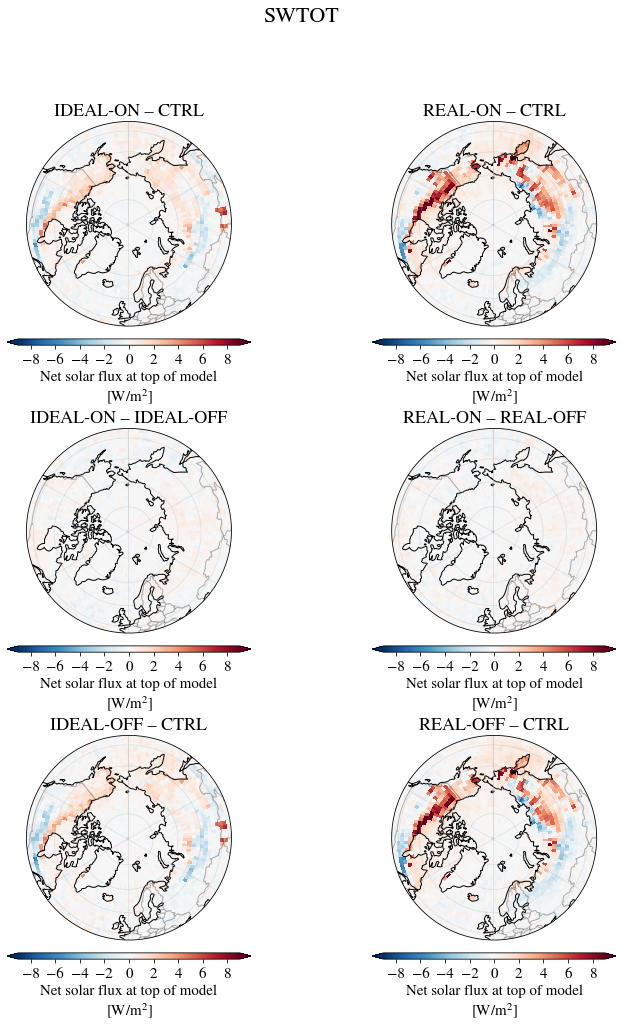

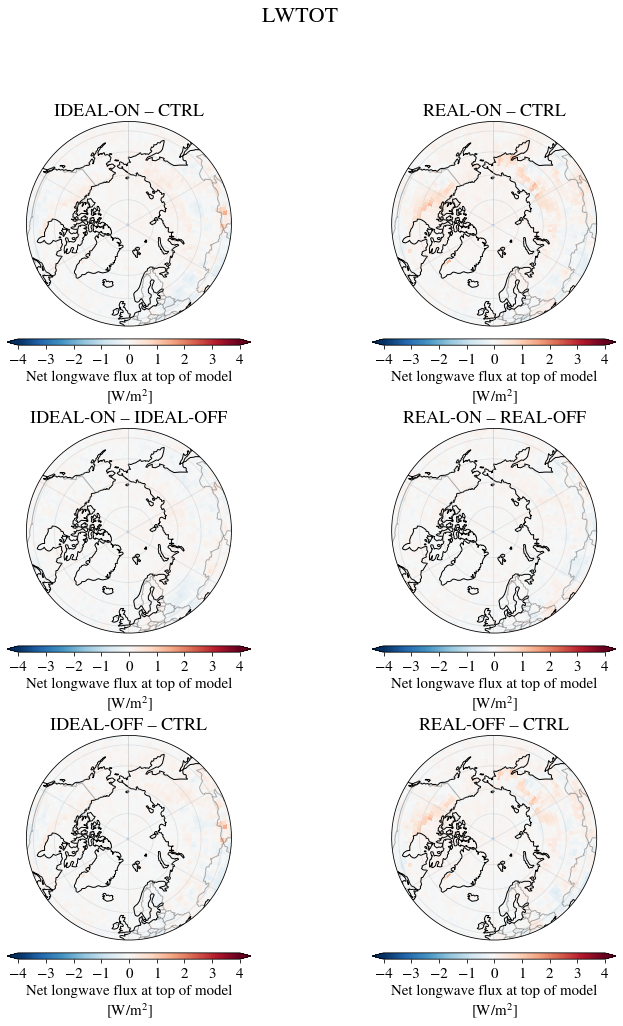

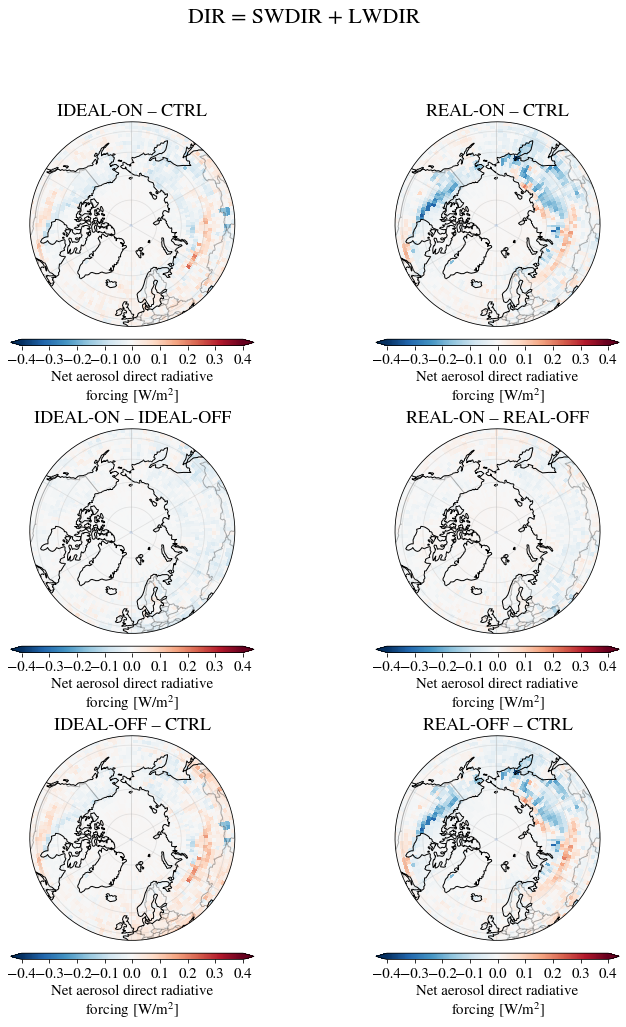

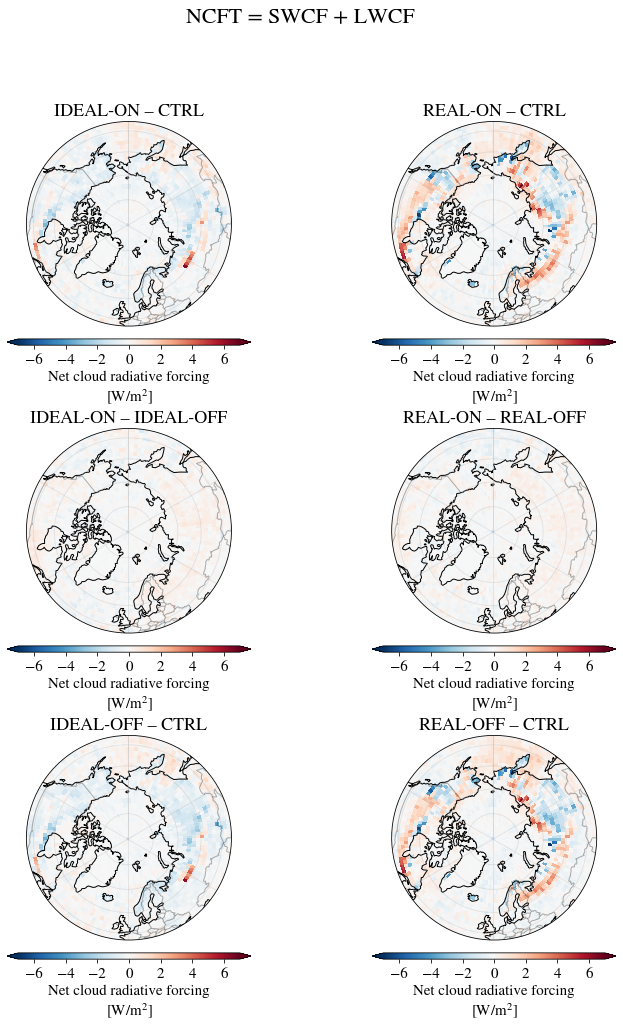

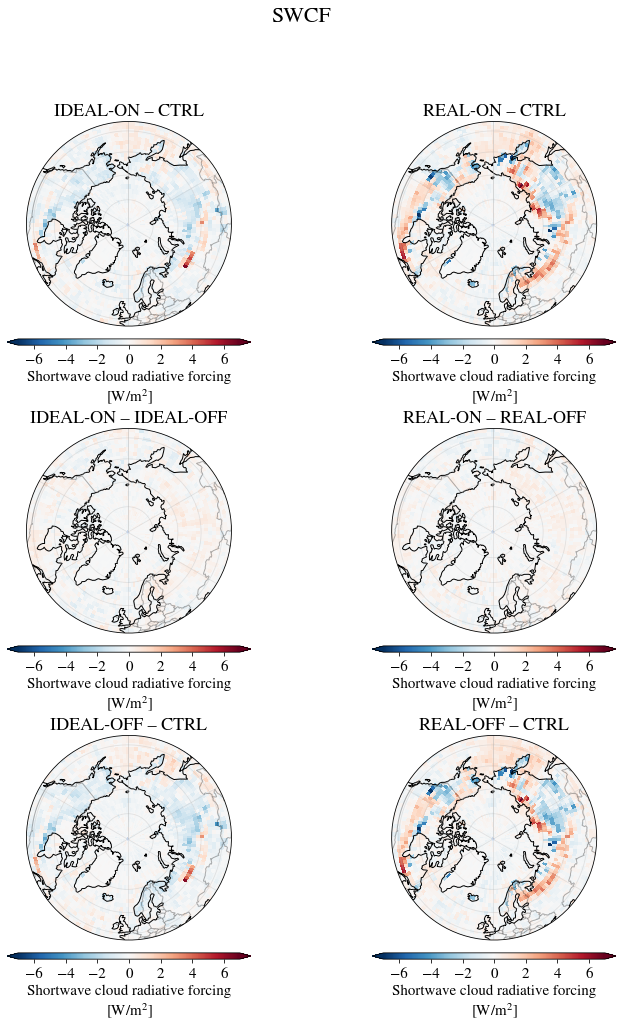

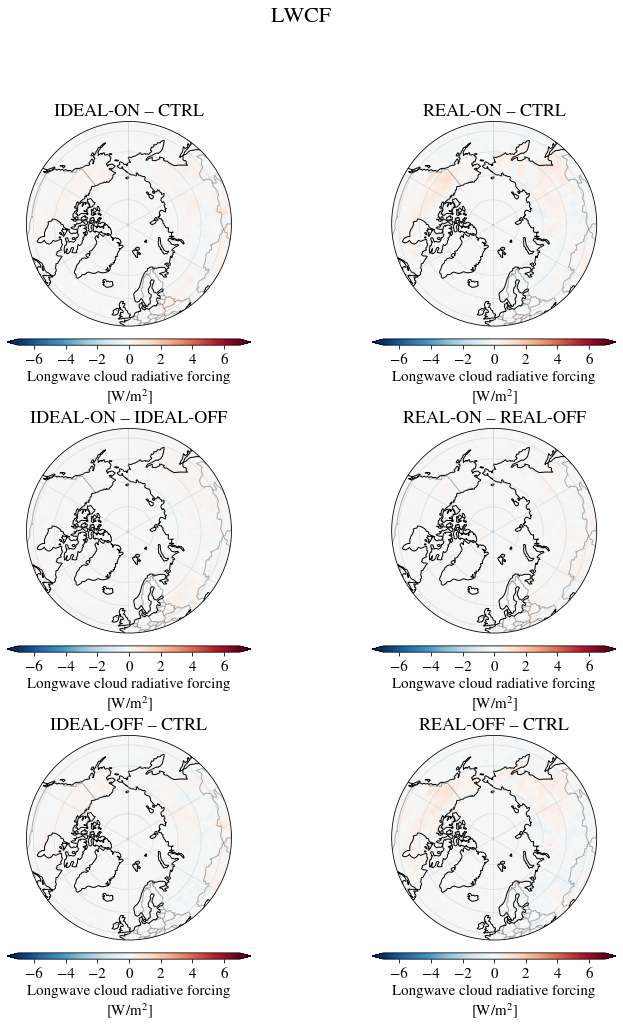

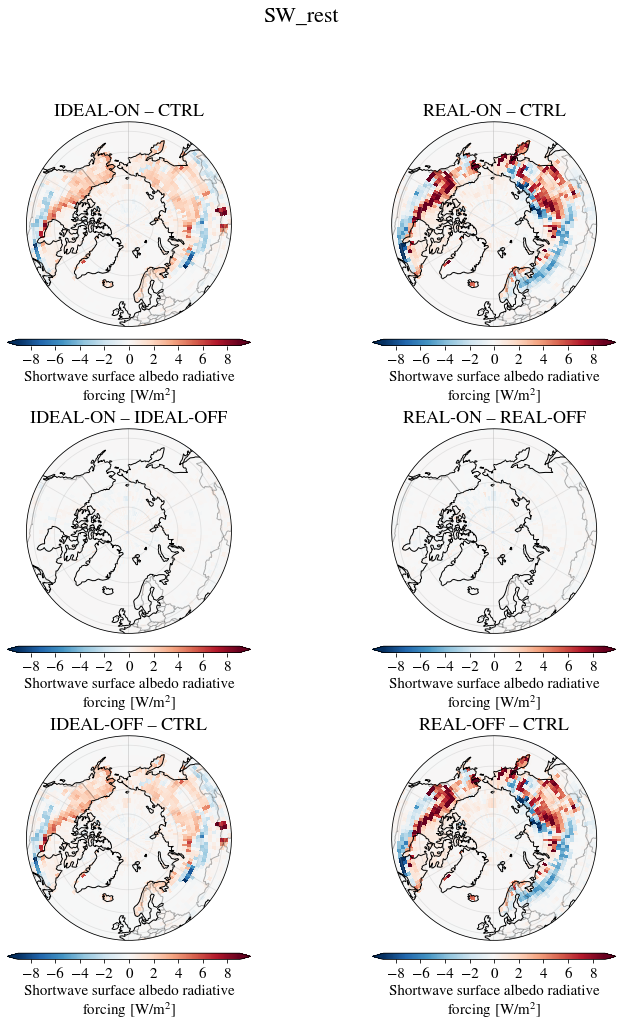

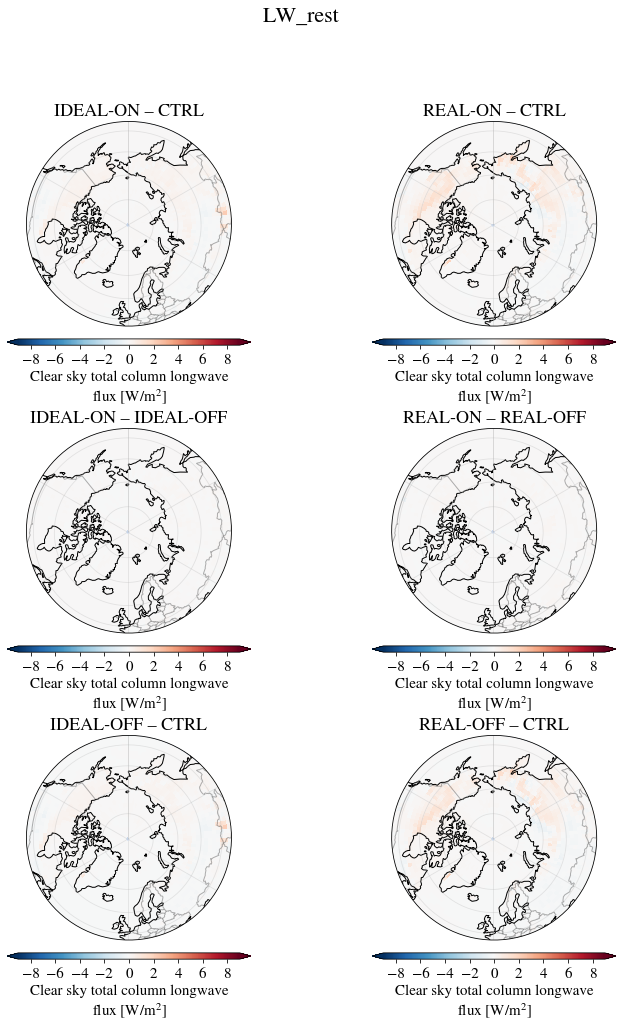

In [9]:
for var in ['FSNT', 'FLNT', 'DIR', 'NCFT', 'SWCF', 'LWCF', 'SW_rest', 'LW_rest']:
    if var == 'FSNT': title = 'SWTOT'; vmax = 9
    elif var == 'FLNT': title = 'LWTOT'; vmax = 4
    elif var == 'DIR': title = 'DIR = SWDIR + LWDIR'; vmax =0.4
    elif var == 'NCFT': title = 'NCFT = SWCF + LWCF'; vmax=7
    elif var == 'SW_rest': title = var; vmax=9
    else: title = var
    spatial_averages(radiative, var, title, relative=False, vmax = vmax)

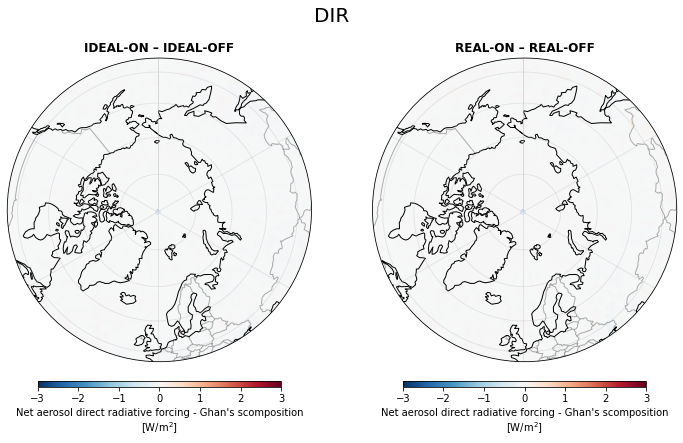

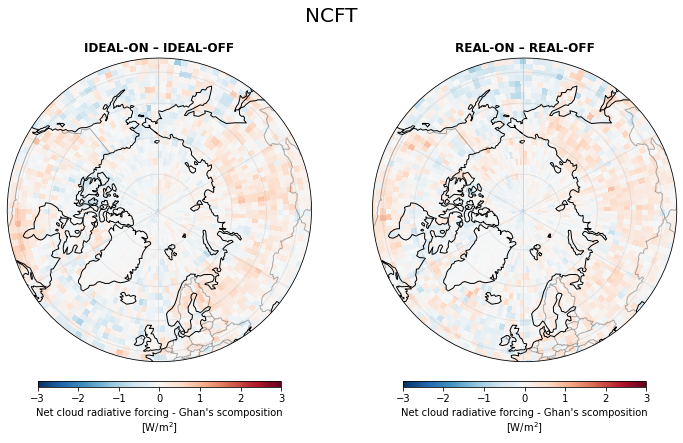

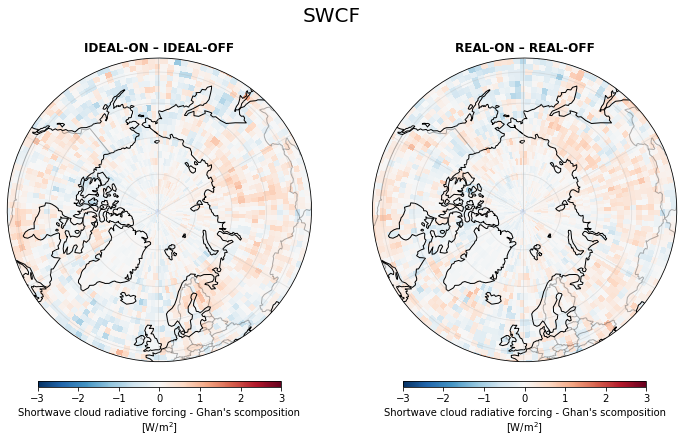

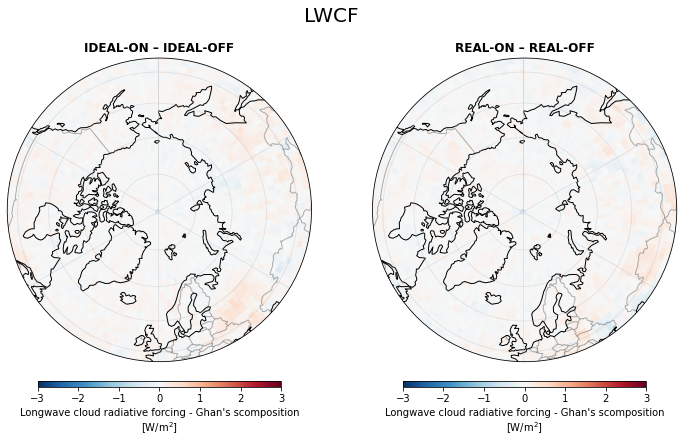

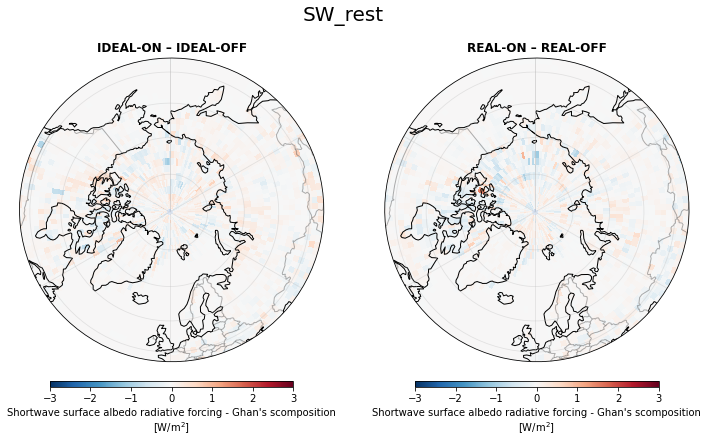

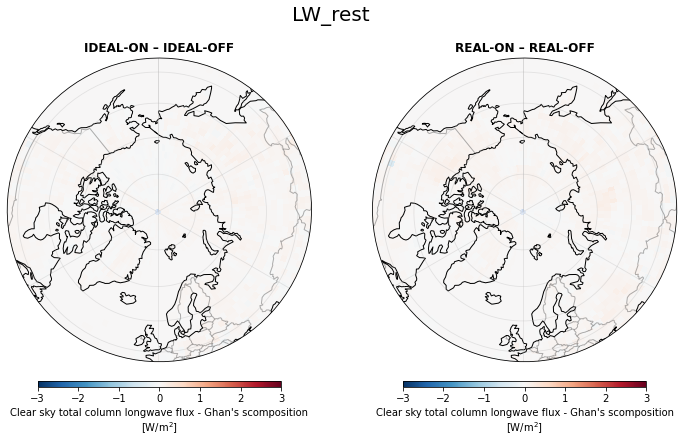

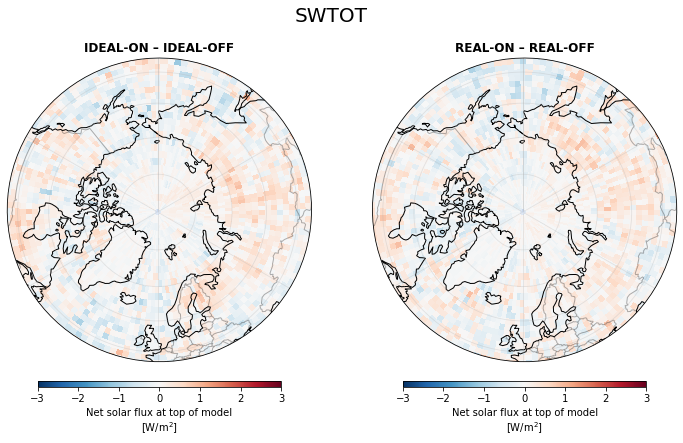

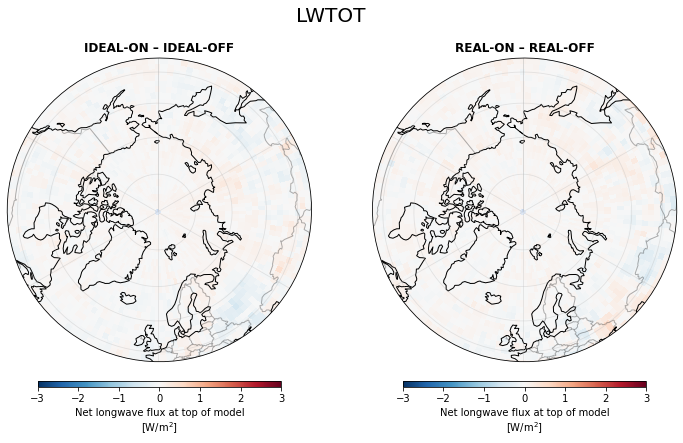

In [22]:
for var in ['DIR', 'NCFT', 'SWCF', 'LWCF', 'SW_rest', 'LW_rest', 'FSNT', 'FLNT']:

    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=[12,7], 
                             subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)

    variable=var
    title=var
    if var == 'FSNT': title = 'SWTOT'
    if var == 'FLNT': title = 'LWTOT'
    plot_difference(radiative, 'IDEAL-ON', 'IDEAL-OFF', variable, ax=axes.flat[0], vmax=3)
    plot_difference(radiative, 'REAL-ON', 'REAL-OFF', variable, ax=axes.flat[1], vmax=3)
    plt.suptitle(title, size=20)
    plt.show()

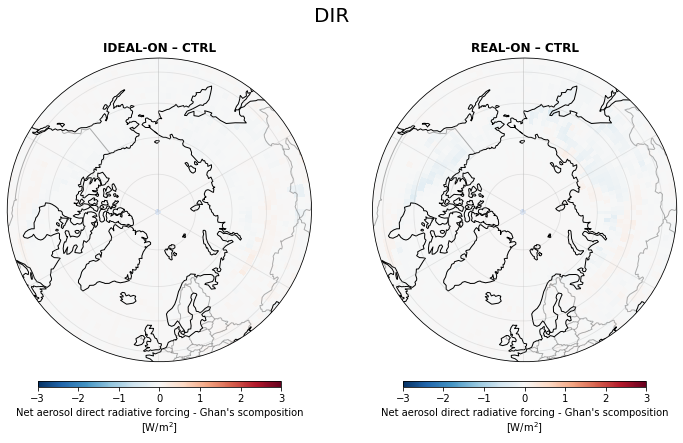

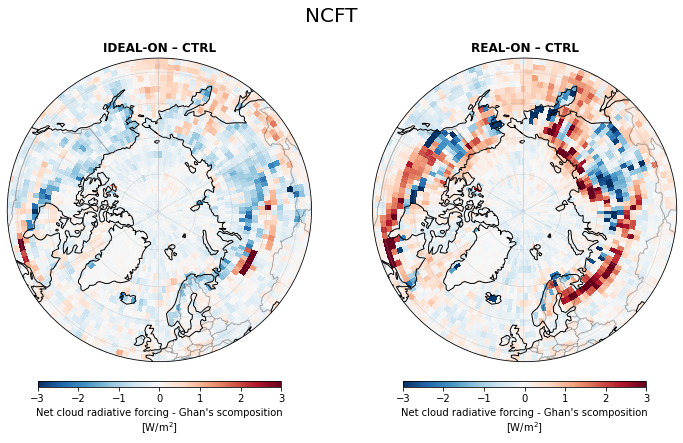

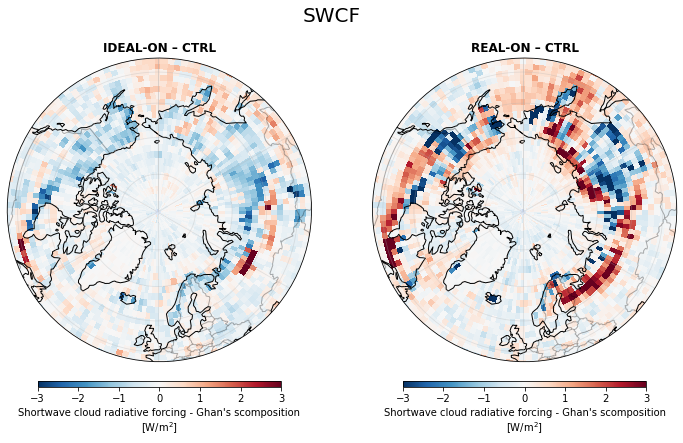

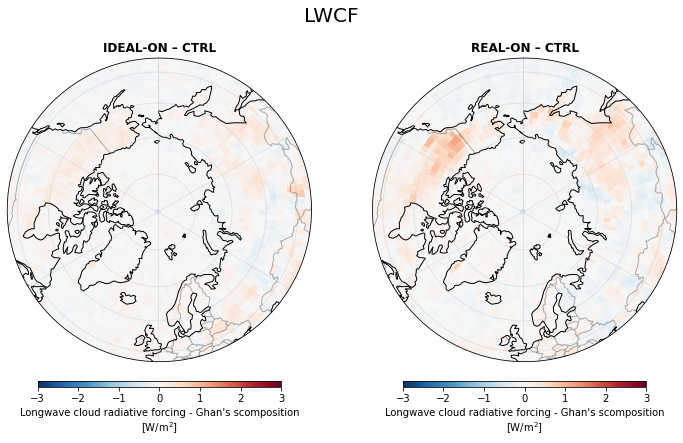

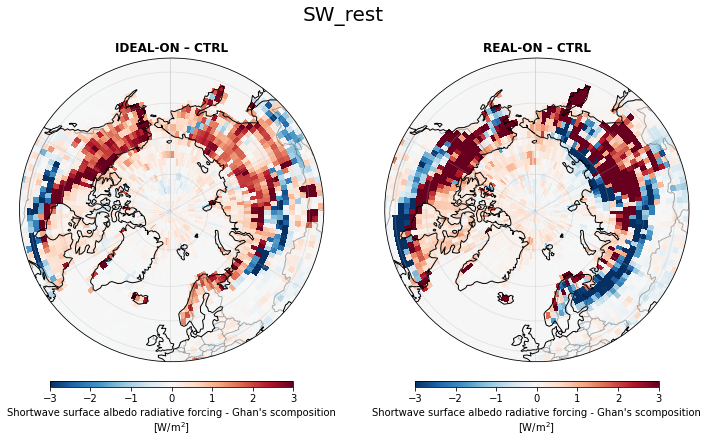

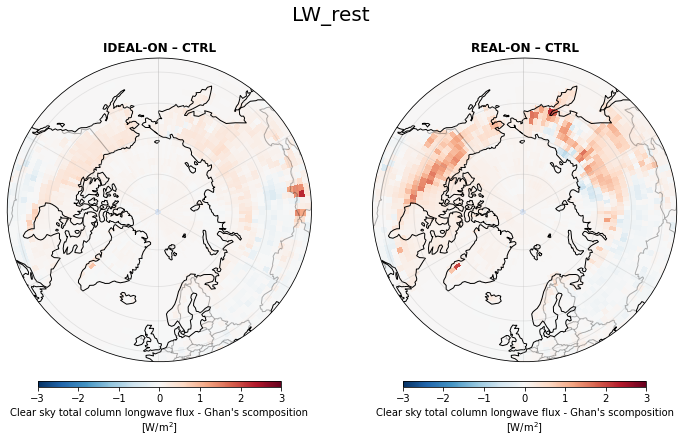

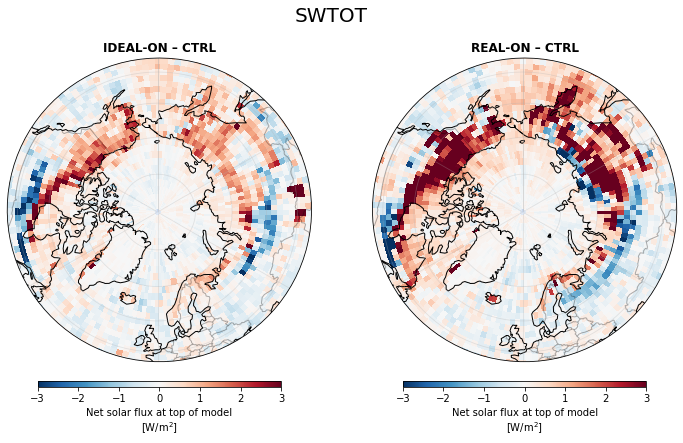

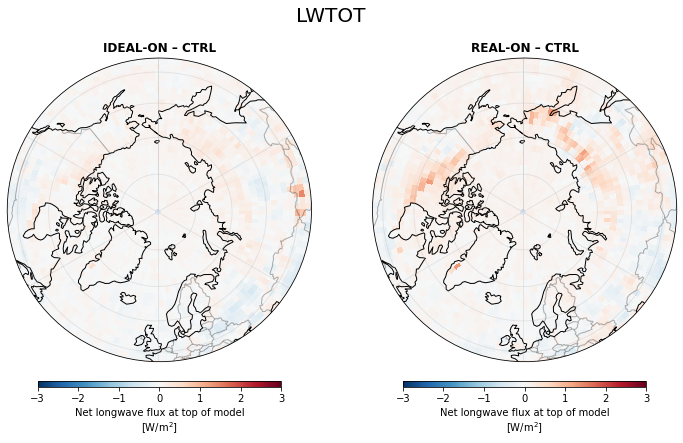

In [23]:
for var in ['DIR', 'NCFT', 'SWCF', 'LWCF', 'SW_rest', 'LW_rest', 'FSNT', 'FLNT']:

    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=[12,7], 
                             subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)

    variable=var
    title=var
    if var == 'FSNT': title = 'SWTOT'
    if var == 'FLNT': title = 'LWTOT'
    plot_difference(radiative, 'IDEAL-ON', 'CTRL', variable, ax=axes.flat[0], vmax=3)
    plot_difference(radiative, 'REAL-ON', 'CTRL', variable, ax=axes.flat[1], vmax=3)
    plt.suptitle(title, size=20)
    plt.show()

In [ ]:
def plot_difference(da_dict, case1, case2, variable, ax = None, lev=False, **kwargs):
    
    diff = (da_dict[case1][variable].mean('time')-da_dict[case2][variable].mean('time'))#/da_dict[case2][variable].groupby('time.year').sum('time').mean('year')
    if lev: diff=diff.sum('lev')#.where(da_dict[case1].LANDFRAC.mean('time')>0.)
    single_pft_map(diff, ax = ax, title=case1+' – '+case2, cmap='RdBu_r', extent_lat =45.,**kwargs)
        
def plot_difference_by_season(da_dict, case1, case2, variable, title, lev=False,**kwargs):
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    
    diff = (da_dict[case1][variable].groupby('time.season').mean('time')-da_dict[case2][variable].groupby('time.season').mean('time'))
    if lev: diff=diff.sum('lev').where(da_dict[case1].LANDFRAC.mean('time')>0.)
        
    fig, axes = plt.subplots(1,4, figsize=[17,5], subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)
    
    for i, season in enumerate(seasons):
        single_pft_map(diff.sel(season=season), ax = axes.flat[i], title=season, cmap='RdBu_r', extent_lat =45.,**kwargs)
    plt.suptitle(title+': '+case1+' – '+case2, size=15)
    plt.show()